### SKew Correction (two sections, bottom points alignment)

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.util import invert

In [38]:
def correct_skew(image, n_sections=2):
    image_copy = image.copy()
    # Convert to grayscale
    gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
    
    pad_size = int(gray.shape[0] * 0.5)  # Adjust padding size as needed
    padded_image = cv2.copyMakeBorder(gray, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, value=0)
    
    # Threshold the image to obtain a binary image (assuming characters are darker)
    _, binary = cv2.threshold(padded_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(max_contour)
    
    # Divide the ROI into n vertical sections
    roi_img = padded_image[y:y+h, x:x+w]
    section_width = w // n_sections     
    # Initialize variables to store bottommost points in each section
    bottom_points = []
    
    # Find the bottommost points in each section
    for i in range(n_sections):
        section = roi_img[:, i*section_width:(i+1)*section_width]
        bottom_point = find_bottom_point(section)
        bottom_point = (bottom_point[0] + i*section_width + x, bottom_point[1] + y)  # Shift coordinates to original image
        bottom_points.append(bottom_point)
    
    # Fit a line passing through these points
    [vx, vy, x, y] = cv2.fitLine(np.array(bottom_points), cv2.DIST_L2, 0, 0.01, 0.01)
    
    # Calculate the angle of the line with the horizontal axis
    angle = np.degrees(np.arctan2(vy, vx))
    
    # Ensure angle is a float
    angle = float(angle)
    
    # Rotate the image to correct skew
    rotated_image = rotate_image(padded_image, angle)
    
    cropped_resized_image = crop_and_resize(rotated_image, gray.shape,pad_size)
    bgr_image = cv2.cvtColor(cropped_resized_image, cv2.COLOR_GRAY2BGR)
    bgr_image[bgr_image<255]=0
    return bgr_image, gray

def crop_and_resize(image, original_size,pad_size):
    image_copy = image.copy()
    
    _, binary = cv2.threshold(image_copy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the maximum area
    max_contour = max(contours, key=cv2.contourArea)
    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(max_contour)
    
    if w>original_size[1] or h > original_size[0]:
        cropped_image = image_copy[y:y+h, x:x+w]
        resized_image = cv2.resize(cropped_image, (original_size[1], original_size[0]))
    else:
        # Calculate top-left corner of the crop region
        centre_x = x + w/2
        centre_y = y +h/2
        x_crop = int(centre_x - original_size[0] / 2)
        y_crop = int(centre_y - original_size[1] / 2)

        # Ensure the crop region fits within the image boundaries
        x_crop = max(0, x_crop)
        y_crop = max(0, y_crop) 
        # Crop the image
        cropped_image = image[y_crop:y_crop+original_size[1], x_crop:x_crop+original_size[0]]
        resized_image = cropped_image   
    return resized_image

def find_bottom_point(section, threshold=0):
    # Find the lowest point in the section
    bottom_row_index = len(section) - 1 - np.argmax(np.sum(section[::-1], axis=1) > threshold)
    bottom_point = [np.argmax(section[bottom_row_index]), bottom_row_index]
    return bottom_point

def rotate_image(image, angle):
    # Image dimensions
    height, width = image.shape[:2]
    if image.dtype != np.uint8:
        image = (image).astype(np.uint8) 
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), float(angle), 1)
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

(300, 300, 3)


C:\Users\Nandini\AppData\Local\Temp\ipykernel_15004\2136354488.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle = float(angle)


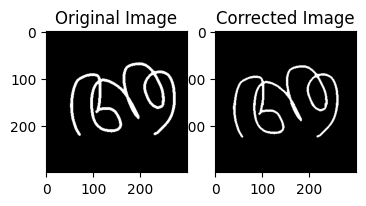

In [40]:
img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\Data Dumps\PREPROCESSING\FILTERED\pre1_character_3334\pre1_character_3334_149.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

corrected_image, original_image = correct_skew(img, n_sections=2)

print(np.shape(corrected_image))
# Plot original and corrected images side by side
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

# Plot original image with PCA line
axes[0].imshow(original_image,cmap = 'gray')
axes[0].set_title('Original Image')
# Plot corrected image
axes[1].imshow(corrected_image)
axes[1].set_title('Corrected Image')
plt.show()

In [41]:
# # SKEW CORRECTION ALL IMAGES

# # Input and output directories
# input_folder = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\Data Dumps\PREPROCESSING\FILTERED'
# output_folder = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\Data Dumps\PREPROCESSING\SKEW_CORRECTED'

# # Traverse through directories and process images
# for root, dirs, files in os.walk(input_folder):
#     for subdir in dirs:
#         input_subdir = os.path.join(root, subdir)
#         output_subdir = os.path.join(output_folder, 'pre2_' + subdir[5:])
        
#         # Create output subdirectory if it doesn't exist
#         if not os.path.exists(output_subdir):
#             os.makedirs(output_subdir)

#         # Process images in the subdirectory
#         for file in os.listdir(input_subdir):
#             if file.endswith('.png') or file.endswith('.jpg'):
#                 img_path = os.path.join(input_subdir, file)
#                 output_image_path = os.path.join(output_subdir, 'pre2_' + file[5:])
#                 img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#                 # Detect and correct skew
#                 corrected_image,_ = correct_skew(img)
#                 # Save the corrected image
#                 cv2.imwrite(output_image_path, (corrected_image ).astype(np.uint8))
#                 # print(f"{output_image_path} saved.")

# print("Skew correction process completed.")

C:\Users\Nandini\AppData\Local\Temp\ipykernel_15004\2136354488.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angle = float(angle)


Skew correction process completed.


### SKew Correction (Bounding box trial)

C:\Users\Nandini\AppData\Local\Temp\ipykernel_21912\1961007082.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


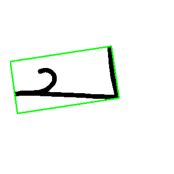

In [29]:
# BOUNDING BOX MIN

img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3354\character_3354_13.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0
image_copy = new_img.copy()

# Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

# Apply thresholding to get a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours of the characters
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rotated bounding boxes around each character on a copy of the image
image_with_boxes = image_copy.copy()
for contour in contours:
    # Get rotated bounding box
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Draw the rotated bounding box
    cv2.drawContours(image_with_boxes, [box], 0, (0, 255, 0), 2)

# Convert BGR image to RGB for displaying with matplotlib
image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

# Display the image with rotated bounding boxes using matplotlib
plt.figure(figsize=(2, 2))
plt.imshow(image_with_boxes_rgb)
plt.axis('off')  # Hide axis labels
plt.show()

Alignment Angle: 82.01673889160156


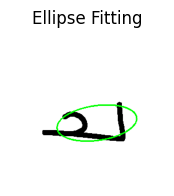

In [18]:
# ELLIPSE FITTING

img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3354\character_3354_48.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0
image_copy = new_img.copy()

# Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)


# Apply thresholding to get a binary image
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours of the characters
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through contours
for contour in contours:
    # Fit an ellipse around the contour
    ellipse = cv2.fitEllipse(contour)
    center, axes, angle = ellipse
    
    # Calculate the angle of rotation needed for alignment
    alignment_angle = angle  # Assuming horizontal alignment
    
    # Optionally adjust for vertical alignment (if needed)
    # alignment_angle = angle + 90  # For vertical alignment
    
    # Print or use alignment_angle for further processing
    print(f"Alignment Angle: {alignment_angle}")

    # Draw ellipse on a copy of the image (for visualization)
    image_with_ellipse = image_copy.copy()
    cv2.ellipse(image_with_ellipse, ellipse, (0, 255, 0), 2)  # Draw ellipse in green color
    
    # Convert BGR image to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image_with_ellipse, cv2.COLOR_BGR2RGB)

    # Display the image with ellipse using matplotlib
    plt.figure(figsize=(2, 2))
    plt.imshow(image_rgb)
    plt.title('Ellipse Fitting')
    plt.axis('off')  # Hide axis labels
    plt.show()

    # Optionally, you can break after processing one contour
    # break


### Skew Detection Projection Profile Trial

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

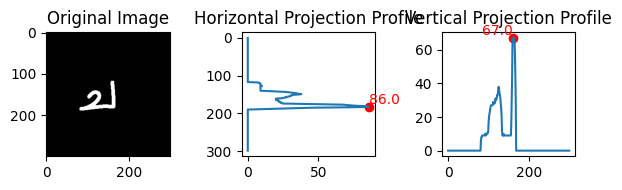

In [3]:
img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3354\character_3354_32.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0
image = new_img.copy()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

image = gray/255
inverted_image = 1 - image


# Step 2: Compute horizontal projection profile
horizontal_projection = np.sum(inverted_image, axis=1)

# Step 3: Compute vertical projection profile
vertical_projection = np.sum(inverted_image, axis=0)

# Find indices of maximum values
max_h = np.argmax(horizontal_projection)
max_v = np.argmax(vertical_projection)

# Step 4: Plotting
plt.figure(figsize=(6, 2))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(inverted_image, cmap='gray')
plt.title('Original Image')

# Horizontal projection profile
plt.subplot(1, 3, 2)
plt.plot(horizontal_projection, range(len(horizontal_projection)))
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.scatter(horizontal_projection[max_h],max_h, color='red', label=f'Max: {horizontal_projection[max_h]}')
plt.text(horizontal_projection[max_h], max_h, f'{horizontal_projection[max_h]}', ha='left', va='bottom', color='red')
plt.title('Horizontal Projection Profile')

# Vertical projection profile
plt.subplot(1, 3, 3)
plt.plot(range(len(vertical_projection)),vertical_projection)
plt.scatter(max_v, vertical_projection[max_v], color='red', label=f'Max: {vertical_projection[max_v]}')
plt.text(max_v, vertical_projection[max_v], f'{vertical_projection[max_v]}', ha='right', va='bottom', color='red')
plt.title('Vertical Projection Profile')

plt.tight_layout()
plt.show()


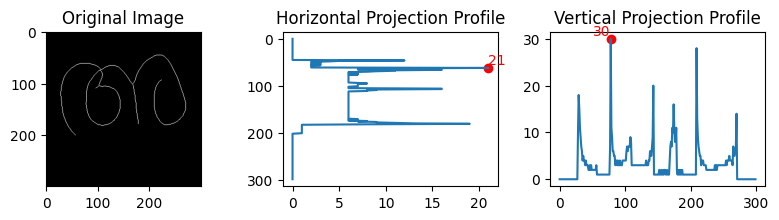

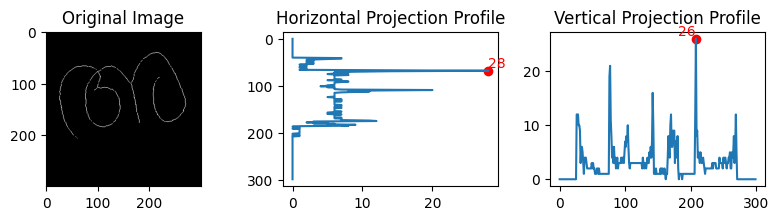

In [21]:
def rotate_image(image, angle):
    # Image dimensions
    height, width = image.shape[:2]
    if image.dtype != np.uint8:
        image = (image).astype(np.uint8) 
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), float(angle), 1)
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

def draw_profile(image):
    horizontal_projection = np.sum(image, axis=1)
    vertical_projection = np.sum(image, axis=0)
    
    # Find indices of maximum values
    max_h = np.argmax(horizontal_projection)
    max_v = np.argmax(vertical_projection)
    
    # Plotting
    fig = plt.figure(figsize=(8, 4))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    # Horizontal projection profile
    plt.subplot(2, 3, 2)
    plt.plot(horizontal_projection, range(len(horizontal_projection)))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.scatter(horizontal_projection[max_h],max_h, color='red', label=f'Max: {horizontal_projection[max_h]}')
    plt.text(horizontal_projection[max_h], max_h, f'{horizontal_projection[max_h]}', ha='left', va='bottom', color='red')
    plt.title('Horizontal Projection Profile')

    # Vertical projection profile
    plt.subplot(2, 3, 3)
    plt.plot(range(len(vertical_projection)),vertical_projection)
    plt.scatter(max_v, vertical_projection[max_v], color='red', label=f'Max: {vertical_projection[max_v]}')
    plt.text(max_v, vertical_projection[max_v], f'{vertical_projection[max_v]}', ha='right', va='bottom', color='red')
    plt.title('Vertical Projection Profile')
    
    plt.tight_layout()
    return fig

# Load your image (replace 'path_to_your_image' with your actual image path)
img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3333\character_3333_22.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0

# Convert to grayscale
gray = cv2.cvtColor(new_img.copy(), cv2.COLOR_BGR2GRAY)

image = gray/255
image = 1 - image

# Thresholding (if necessary, depending on your input)
_, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

# Perform thinning using scikit-image
skeleton = morphology.thin(binary)
image = skeleton

# Correct the skew of the image using OpenCV
angle = 4
rotated_image = rotate_image(image, angle)

fig_1 = draw_profile(image)
fig_2 = draw_profile(rotated_image)


Skew Angle:  4.0


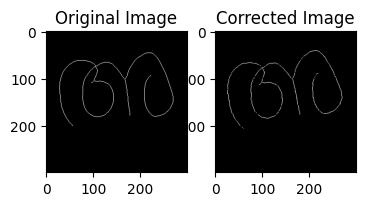

In [19]:
def rotate_image(image, angle):
    # Image dimensions
    height, width = image.shape[:2]
    if image.dtype != np.uint8:
        image = (image).astype(np.uint8) 
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width // 2, height // 2), float(angle), 1)
    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

def correct_skew_iterative(image, angle_range=(-60.0, 45.0), angle_step=1.0):
    
    # Calculate horizontal projection profile of the original image
    horizontal_projection_original = np.sum(image, axis=1)
    max_h = np.argmax(horizontal_projection_original)
    
    # Initialize variables to store best angle and its corresponding peak value
    best_angle = 0
    max_peak_value = horizontal_projection_original[max_h]
    
    # Iterate through angles within the specified range
    for angle in np.arange(angle_range[0], angle_range[1] + angle_step, angle_step):
        # Rotate the image with the current angle
        rotated_image = rotate_image(image, angle)
        
        # Calculate horizontal projection profile after rotation
        horizontal_projection_rotated = np.sum(rotated_image, axis=1)
        max_peak_value_rotated = np.max(horizontal_projection_rotated)
        
        # Update best angle if the current angle gives a higher peak value
        if max_peak_value_rotated > max_peak_value:
            max_peak_value = max_peak_value_rotated
            best_angle = angle
    
    # Rotate the image with the best angle found
    rotated_image = rotate_image(image, best_angle)
    print('Skew Angle: ',best_angle)
    return rotated_image

# Load your image (replace 'path_to_your_image' with your actual image path)
img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3333\character_3333_22.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0

# Convert to grayscale
gray = cv2.cvtColor(new_img.copy(), cv2.COLOR_BGR2GRAY)

image = gray/255
image = 1 - image

# Thresholding (if necessary, depending on your input)
_, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

# Perform thinning using scikit-image
skeleton = morphology.thin(binary)
image = skeleton

# Correct skewness based on horizontal projection profile with binary search
corrected_image = correct_skew_iterative(image)

# Plot original and corrected images side by side
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

# Plot original image with PCA line
axes[0].imshow(image,cmap='gray')
axes[0].set_title('Original Image')
# Plot corrected image
axes[1].imshow(corrected_image,cmap='gray')
axes[1].set_title('Corrected Image')
plt.show()

In [ ]:
# # SKEW CORRECTION ALL IMAGES

# # Input and output directories
# input_folder = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\Data Dumps\CLEANED_DATA'
# output_folder = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\Data Dumps\SKEW_CORRECTED'


# # Traverse through directories and process images
# for root, dirs, files in os.walk(input_folder):
#     for subdir in dirs:
#         input_subdir = os.path.join(root, subdir)
#         output_subdir = os.path.join(output_folder, 'skew_corrected_' + subdir)
        
#         # Create output subdirectory if it doesn't exist
#         if not os.path.exists(output_subdir):
#             os.makedirs(output_subdir)

#         # Process images in the subdirectory
#         for file in os.listdir(input_subdir):
#             if file.endswith('.png') or file.endswith('.jpg'):
#                 img_path = os.path.join(input_subdir, file)
#                 output_image_path = os.path.join(output_subdir, 'skew_corrected_' + file)

#                 img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
#                 alpha2 = np.asarray(img[:,:,3])
#                 alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
#                 new_img = np.ones((300,300,3))
#                 new_img = (255 - alpha2_broadcasted)
#                 new_img = cv2.resize(new_img, (300, 300))
#                 new_img[new_img<255] = 0

#                 # Convert to grayscale
#                 gray = cv2.cvtColor(new_img.copy(), cv2.COLOR_BGR2GRAY)

#                 image = gray/255
#                 image = 1 - image
                
#                 # Thresholding (if necessary, depending on your input)
#                 _, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)

#                 # Perform thinning using scikit-image
#                 skeleton = morphology.thin(binary)
#                 image = skeleton
#                 if image.dtype != np.uint8:
#                     image = (image).astype(np.uint8)
                
#                 # Detect and correct skew
#                 corrected_image,_ = correct_skew(image)
                
#                 # Save the corrected image
#                 cv2.imwrite(output_image_path, (corrected_image * 255).astype(np.uint8))
#                 print(f"{output_image_path} saved.")

# print("Skew correction process completed.")

### Thinning Algorithm

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.util import invert

In [2]:
def thin_image(image):
    gray = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    binary = invert(binary)
    skeleton = morphology.thin(binary)
    return skeleton

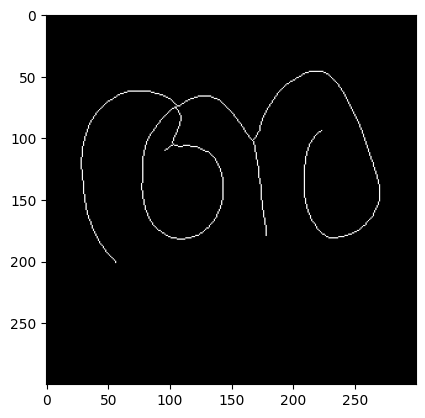

In [43]:
# Load your image (replace 'path_to_your_image' with your actual image path)
img_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3333\character_3333_22.png'
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
alpha2 = np.asarray(img[:,:,3])
alpha2_broadcasted = np.stack([alpha2] * 3, axis=-1)
new_img = np.ones((300,300,3))
new_img = (255 - alpha2_broadcasted)
new_img = cv2.resize(new_img, (300, 300))
new_img[new_img<255] = 0

# Convert to grayscale
gray = cv2.cvtColor(new_img.copy(), cv2.COLOR_BGR2GRAY)


image = gray/255
image = 1 - image   # Invert the binary image because scikit-image expects foreground (white) objects

# Thresholding (if necessary, depending on your input)
_, binary = cv2.threshold(image, 0, 1, cv2.THRESH_BINARY)


# Perform thinning using scikit-image
skeleton = morphology.thin(binary)

# Save or display the resulting image
plt.imshow(skeleton,cmap='gray')
plt.show()

In [ ]:
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
b, g, r, a = cv2.split(img)
if np.all(a == 255):
    rgb_image = cv2.merge([r, g, b])
    rgb_image[rgb_image>0] = 255
    rgb_image = 255 - rgb_image
else:
    rgb_image = cv2.merge([a, a, a])    # Assign alpha values to RGB channels
    rgb_image[rgb_image<255]=0

# Convert to grayscale
gray = cv2.cvtColor(rgb_image.copy(), cv2.COLOR_BGR2GRAY)

# Threshold the image to obtain a binary image (assuming characters are darker)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Example usage
image_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3334\character_3334_232.png'

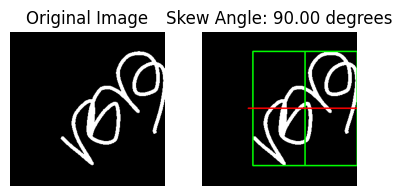

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_skew_angle(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    b, g, r, a = cv2.split(img)
    if np.all(a == 255):
        rgb_image = cv2.merge([r, g, b])
        rgb_image[rgb_image>0] = 255
        rgb_image = 255 - rgb_image
    else:
        rgb_image = cv2.merge([a, a, a])    # Assign alpha values to RGB channels
        rgb_image[rgb_image<255]=0

    # Convert to grayscale
    gray = cv2.cvtColor(rgb_image.copy(), cv2.COLOR_BGR2GRAY)

    # Threshold the image to obtain a binary image (assuming characters are darker)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Ensure at least one contour was found
    if len(contours) == 0:
        print("No contours found.")
        return
    
    # Sort contours by area and find the largest contour (assumed to be the character)
    max_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding box of the contour
    x, y, w, h = cv2.boundingRect(max_contour)
    
    # Define ROI
    roi_img = image[y:y+h, x:x+w]
    
    # Divide the ROI into left and right sections
    half_width = w // 2
    left_roi = roi_img[:, :half_width]
    right_roi = roi_img[:, half_width:]
    
    # Compute contours for left and right sections
    def compute_contour_angle(image_section):
        _, section_binary = cv2.threshold(image_section, 128, 255, cv2.THRESH_BINARY_INV)
        contours, _ = cv2.findContours(section_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 0:
            contour = max(contours, key=cv2.contourArea)
            rect = cv2.minAreaRect(contour)
            return rect[-1]
        return None
    
    # Compute angles for left and right sections
    angle_left = compute_contour_angle(left_roi)
    angle_right = compute_contour_angle(right_roi)
    
    if angle_left is None or angle_right is None:
        print("Unable to compute angles for both sections.")
        return
    
    # Compute skew angle
    skew_angle = (angle_left + angle_right) / 2.0
    
    # Draw bounding boxes and skew angle line on the original image
    original_image = rgb_image.copy()
    skewed_image = original_image.copy()
    
    # Draw bounding boxes around left and right sections
    cv2.rectangle(skewed_image, (x, y), (x + half_width, y + h), (0, 255, 0), 2)  # Left section
    cv2.rectangle(skewed_image, (x + half_width, y), (x + w, y + h), (0, 255, 0), 2)  # Right section
    
    # Draw skew angle line
    center_x = x + half_width
    center_y = y + h // 2
    
    skew_angle_radians = np.deg2rad(skew_angle)
    cos_angle = np.cos(skew_angle_radians)
    sin_angle = np.sin(skew_angle_radians)
    
    length = max(h, half_width) // 2
    pt1 = (int(center_x - length * sin_angle), int(center_y + length * cos_angle))
    pt2 = (int(center_x + length * sin_angle), int(center_y - length * cos_angle))
    
    cv2.line(skewed_image, pt1, pt2, (0, 0, 255), 2)
    
    # Display images using matplotlib
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')
    
    axs[1].imshow(cv2.cvtColor(skewed_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f'Skew Angle: {skew_angle:.2f} degrees')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'D:\Personal\zDocuments\Lachu\Project_MSc\Data\CLEANED_DATA\character_3334\character_3334_232.png'
detect_skew_angle(image_path)
